# Bakery Product classification
| Product Type and Storage Condition classification |


In [53]:
#Imports and Setup

In [54]:
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# ML imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


| **Data Loading and Initial Exploration** |

In [55]:
# =============================================================================
# Load data
all_data = pd.read_csv('./datasets/my_dataset.csv')

storage_mapping = {'storage_1': 0, 'storage_2': 1, 'storage_3': 2}
all_data['storage_condition'] = all_data[['storage_1', 'storage_2', 'storage_3']].idxmax(axis=1).map(storage_mapping)


# Prepare features without storage conditions
features_no_storage = all_data.select_dtypes(include=[np.number]).drop(['Product_Type', 'storage_1', 'storage_2', 'storage_3', 'storage_condition'], axis=1, errors='ignore')

# Prepare features with storage conditions
storage_columns = all_data[['storage_1', 'storage_2', 'storage_3']].values
features_with_storage = pd.concat([
    features_no_storage,
    pd.DataFrame(storage_columns, columns=['storage_1', 'storage_2', 'storage_3'])
], axis=1)

# Prepare target
target = all_data['Product_Type']

# Verify data types
print("\nFeature columns (without storage):", features_no_storage.columns.tolist())
print("Feature columns (with storage):", features_with_storage.columns.tolist())
print("\nData types:")
print(features_no_storage.dtypes)
print("\nTarget values:", target.unique())




Feature columns (without storage): ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55', 'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60', 'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65', 'Feature_66', 'Feature_67', 'Feature_68', 'Feature_69', 'Featu

Visualization Functions

In [56]:
# =============================================================================
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


def plot_accuracy_comparisons(results_without_storage, results_with_storage):
    """Plot accuracy comparisons for models with and without storage conditions."""
    # Filter out None values and get valid results
    valid_models = [
        model for model in results_without_storage.keys()
        if results_without_storage[model] is not None and results_with_storage.get(model) is not None
    ]
    
    accuracies_without = [results_without_storage[model] for model in valid_models]
    accuracies_with = [results_with_storage[model] for model in valid_models]
    
    if not valid_models:
        print("No valid results to plot!")
        return
    
    x = np.arange(len(valid_models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, accuracies_without, width, label='Without Storage')
    bars2 = ax.bar(x + width/2, accuracies_with, width, label='With Storage')

    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracies')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models)
    ax.legend()

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)
    plt.ylim(0, 1)
    plt.show()

4: Model Definition and Classification Functions

In [57]:

# =============================================================================
def classify_model(model, features, target, model_name, pca_components=None, 
                  lda_components=False, return_accuracy=False):
    """Base classification function with dimensionality reduction options."""
    num_classes = len(np.unique(target))
    
    pipeline_steps = [('scaler', StandardScaler())]
    
    if lda_components:
        pipeline_steps.append(('lda', LDA(n_components=num_classes - 1)))
    
    if pca_components:
        pipeline_steps.append(('pca', PCA(n_components=pca_components)))
    
    pipeline_steps.append((model_name, model))
    pipeline = Pipeline(pipeline_steps)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, features, target, cv=cv, 
                              scoring='accuracy', n_jobs=-1)
    
    print(f"\n{model_name.upper()} Classification Results:")
    print(f"Dimensionality Reduction: {'LDA' if lda_components else 'PCA' if pca_components else 'None'}")
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

    y_pred = cross_val_predict(pipeline, features, target, cv=cv, n_jobs=-1)
    plot_confusion_matrix(target, y_pred, f"{model_name.upper()} Confusion Matrix")
    print(classification_report(target, y_pred))
    
    return cv_scores.mean() if return_accuracy else None

# Individual model functions
def knn(features, target, params, **kwargs):
    return classify_model(KNeighborsClassifier(**params), features, target, 'knn', **kwargs)

def svm(features, target, params, **kwargs):
    return classify_model(SVC(**params), features, target, 'svm', **kwargs)

def rf(features, target, params, **kwargs):
    return classify_model(RandomForestClassifier(**params), features, target, 'rf', **kwargs)

def lr(features, target, params, **kwargs):
    return classify_model(LogisticRegression(**params), features, target, 'lr', **kwargs)

def mlp(features, target, params, **kwargs):
    return classify_model(MLPClassifier(**params), features, target, 'mlp', **kwargs)

# =============================================================================


5: Results Management

In [58]:

# =============================================================================
def save_results_to_file(results, filename):
    """Save classification results to a JSON file."""
    try:
        os.makedirs('./results', exist_ok=True)
        file_path = os.path.join('./results', filename)
        with open(file_path, 'w') as file:
            json.dump(results, file, indent=4)
        print(f"Results saved to {file_path}")
    except Exception as e:
        print(f"Error saving results: {str(e)}")
# =============================================================================

# =============================================================================
6: Model Parameters
# =============================================================================

In [59]:

# =============================================================================
best_params = {
    'KNN': {'n_neighbors': 1, 'weights': 'uniform'},
    'Random Forest': {
        'n_estimators': 100,  # Simplified from 160
        'min_samples_split': 2,  # Changed from 15
        'max_depth': None,
        'random_state': 42  # Added for reproducibility
    },
    'SVM': {'C': 1.0, 'kernel': 'linear', 'random_state': 42},  # Simplified
    'Logistic Regression': {
        'C': 1.0,  # Simplified from 37.45...
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42,
        'multi_class': 'auto'  # Added to handle multiclass
    },
    'MLP': {
        'activation': 'logistic',
        'alpha': 0.01,
        'hidden_layer_sizes': (150,),
        'max_iter': 2000,
        'solver': 'adam',
        'learning_rate_init': 0.001,
        'random_state': 42,
        'tol': 1e-4
    }
}

=============================================================================
7: Run Experiments
=============================================================================


Running without storage conditions experiments:

KNN Classification:

KNN Classification Results:
Dimensionality Reduction: None
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000


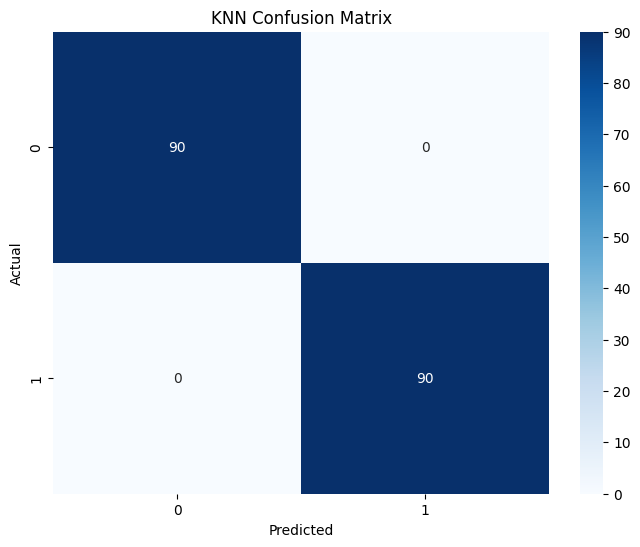

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180


Random Forest Classification:
Error running Random Forest: 'random_forest'

SVM Classification:

SVM Classification Results:
Dimensionality Reduction: None
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833


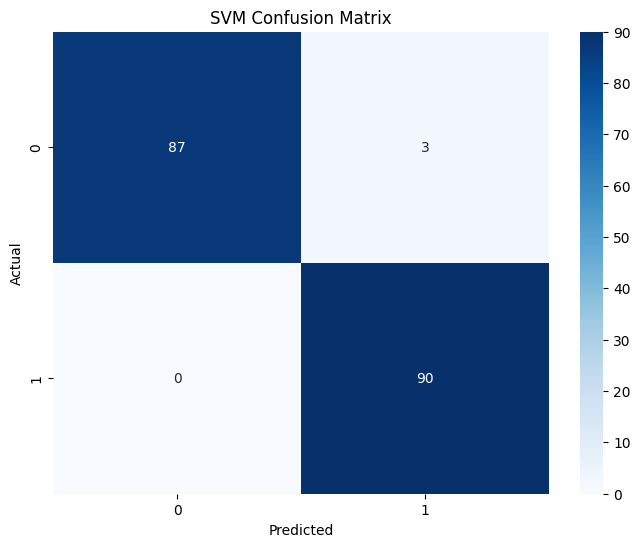

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


Logistic Regression Classification:
Error running Logistic Regression: 'logistic_regression'

MLP Classification:

MLP Classification Results:
Dimensionality Reduction: None
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833


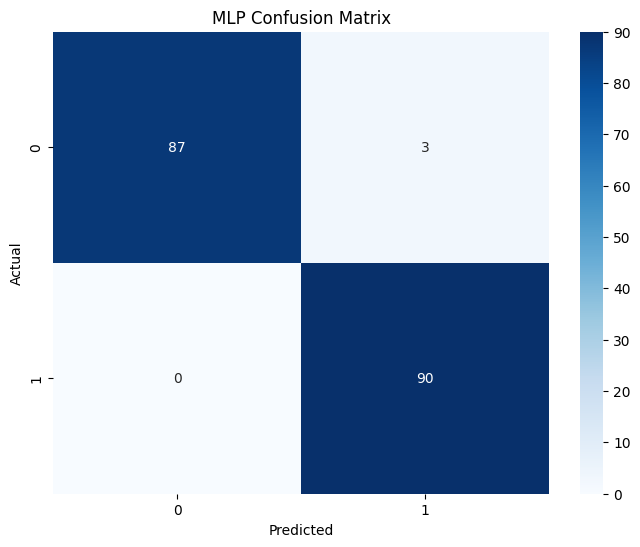

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


Running with storage conditions experiments:

KNN Classification:

KNN Classification Results:
Dimensionality Reduction: None
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000


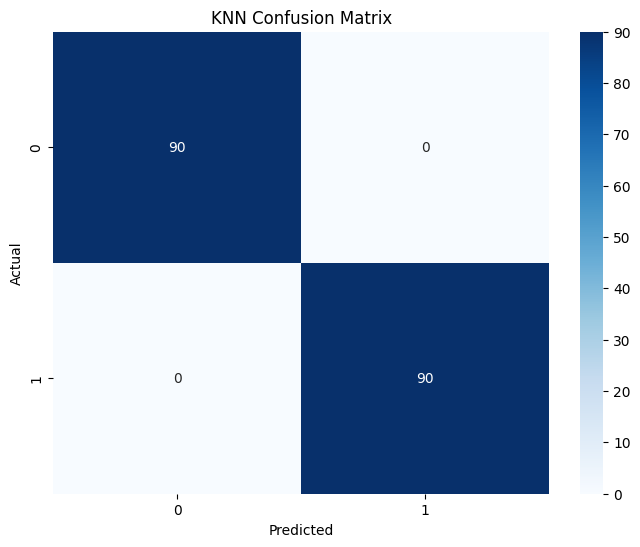

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180


Random Forest Classification:
Error running Random Forest: 'random_forest'

SVM Classification:

SVM Classification Results:
Dimensionality Reduction: None
Cross-Validation Scores: [0.97222222 1.         1.         1.         0.97222222]
Mean CV Accuracy: 0.9889


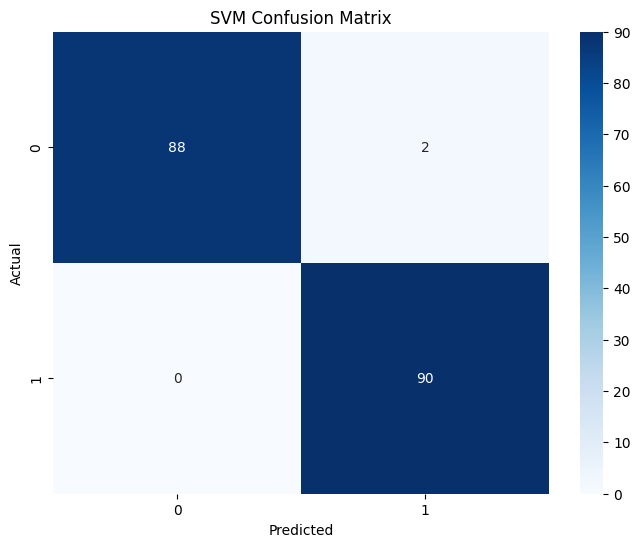

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        90
           1       0.98      1.00      0.99        90

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180


Logistic Regression Classification:
Error running Logistic Regression: 'logistic_regression'

MLP Classification:

MLP Classification Results:
Dimensionality Reduction: None
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833


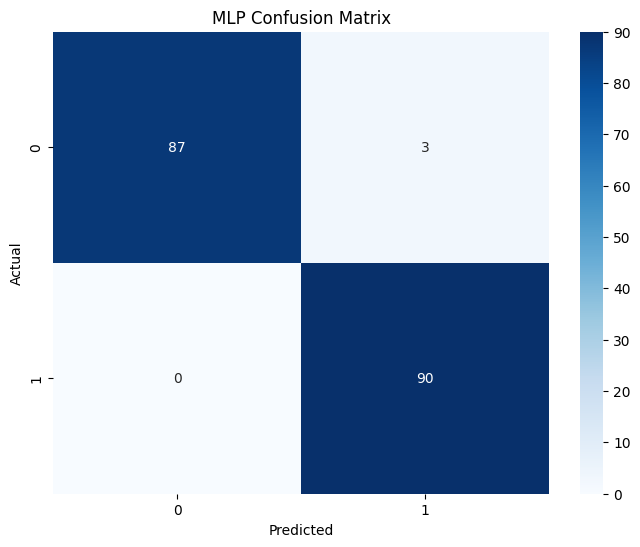

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180

Results saved to ./results\results_without_storage.json
Results saved to ./results\results_with_storage.json


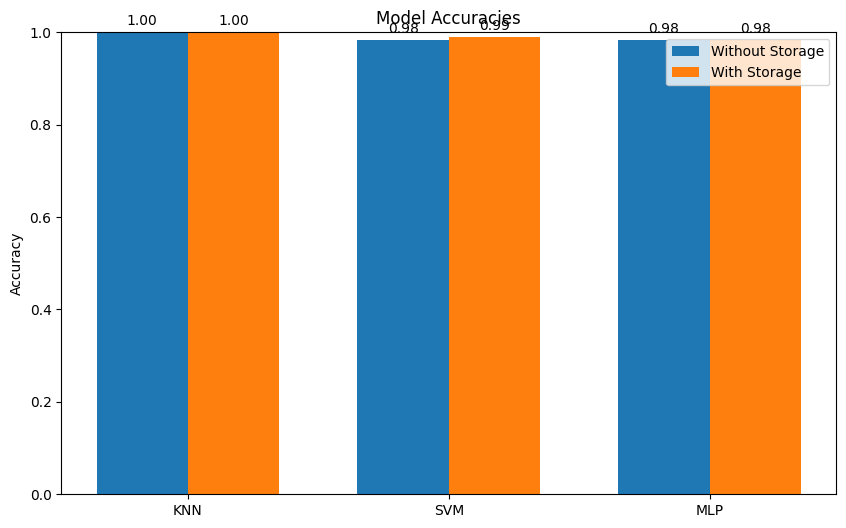

In [60]:
def run_experiments(features, target, params, experiment_name):
    """Run classification experiments with all models."""
    results = {}
    
    print(f"\nRunning {experiment_name} experiments:")
    for model_name, model_params in params.items():
        print(f"\n{model_name} Classification:")
        try:
            model_func = globals()[model_name.lower().replace(" ", "_")]
            accuracy = model_func(
                features, target, model_params, 
                return_accuracy=True
            )
            if accuracy is not None:  # Only store valid results
                results[model_name] = accuracy
            else:
                print(f"Warning: {model_name} returned None accuracy")
        except Exception as e:
            print(f"Error running {model_name}: {str(e)}")
            continue  # Skip failed models instead of storing None
    
    return results

# When running experiments:
try:
    # Run baseline experiments
    results_without_storage = run_experiments(
        features_no_storage, target, best_params, 
        "without storage conditions"
    )

    results_with_storage = run_experiments(
        features_with_storage, target, best_params, 
        "with storage conditions"
    )

    # Only save and plot if we have results
    if results_without_storage and results_with_storage:
        # Save results
        save_results_to_file(results_without_storage, 'results_without_storage.json')
        save_results_to_file(results_with_storage, 'results_with_storage.json')

        # Visualize results
        plot_accuracy_comparisons(results_without_storage, results_with_storage)
    else:
        print("No results to plot - all experiments failed!")

except Exception as e:
    print(f"Error during experiments: {str(e)}")

Dimensionality Reduction Experiments


Classification with PCA:

KNN Classification Results:
Dimensionality Reduction: PCA
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000


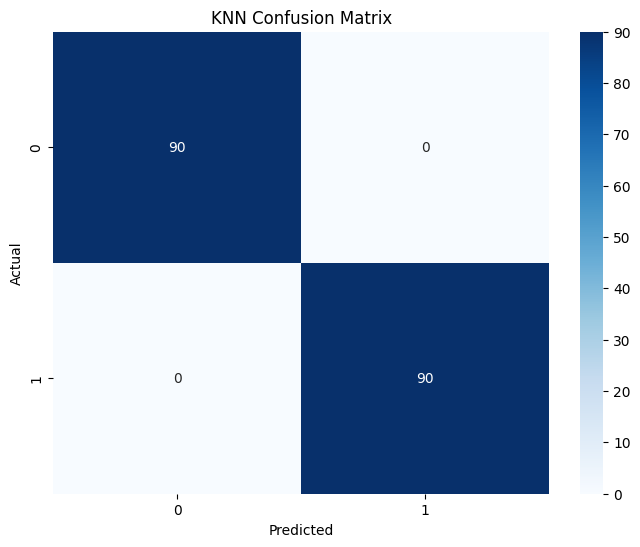

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



KeyError: 'random_forest'

In [61]:
# =============================================================================
# Section 8: Dimensionality Reduction Experiments
# =============================================================================
# PCA experiments
pca_results = {}
print("\nClassification with PCA:")
for model_name, params in best_params.items():
    model_func = globals()[model_name.lower().replace(" ", "_")]
    pca_results[model_name] = model_func(
        features_with_storage, target, params, 
        pca_components=0.95, return_accuracy=True
    )

# LDA experiments
lda_results = {}
print("\nClassification with LDA:")
for model_name, params in best_params.items():
    model_func = globals()[model_name.lower().replace(" ", "_")]
    lda_results[model_name] = model_func(
        features_with_storage, target, params, 
        lda_components=True, return_accuracy=True
    )

# Save dimensionality reduction results
save_results_to_file(pca_results, 'results_pca.json')
save_results_to_file(lda_results, 'results_lda.json')

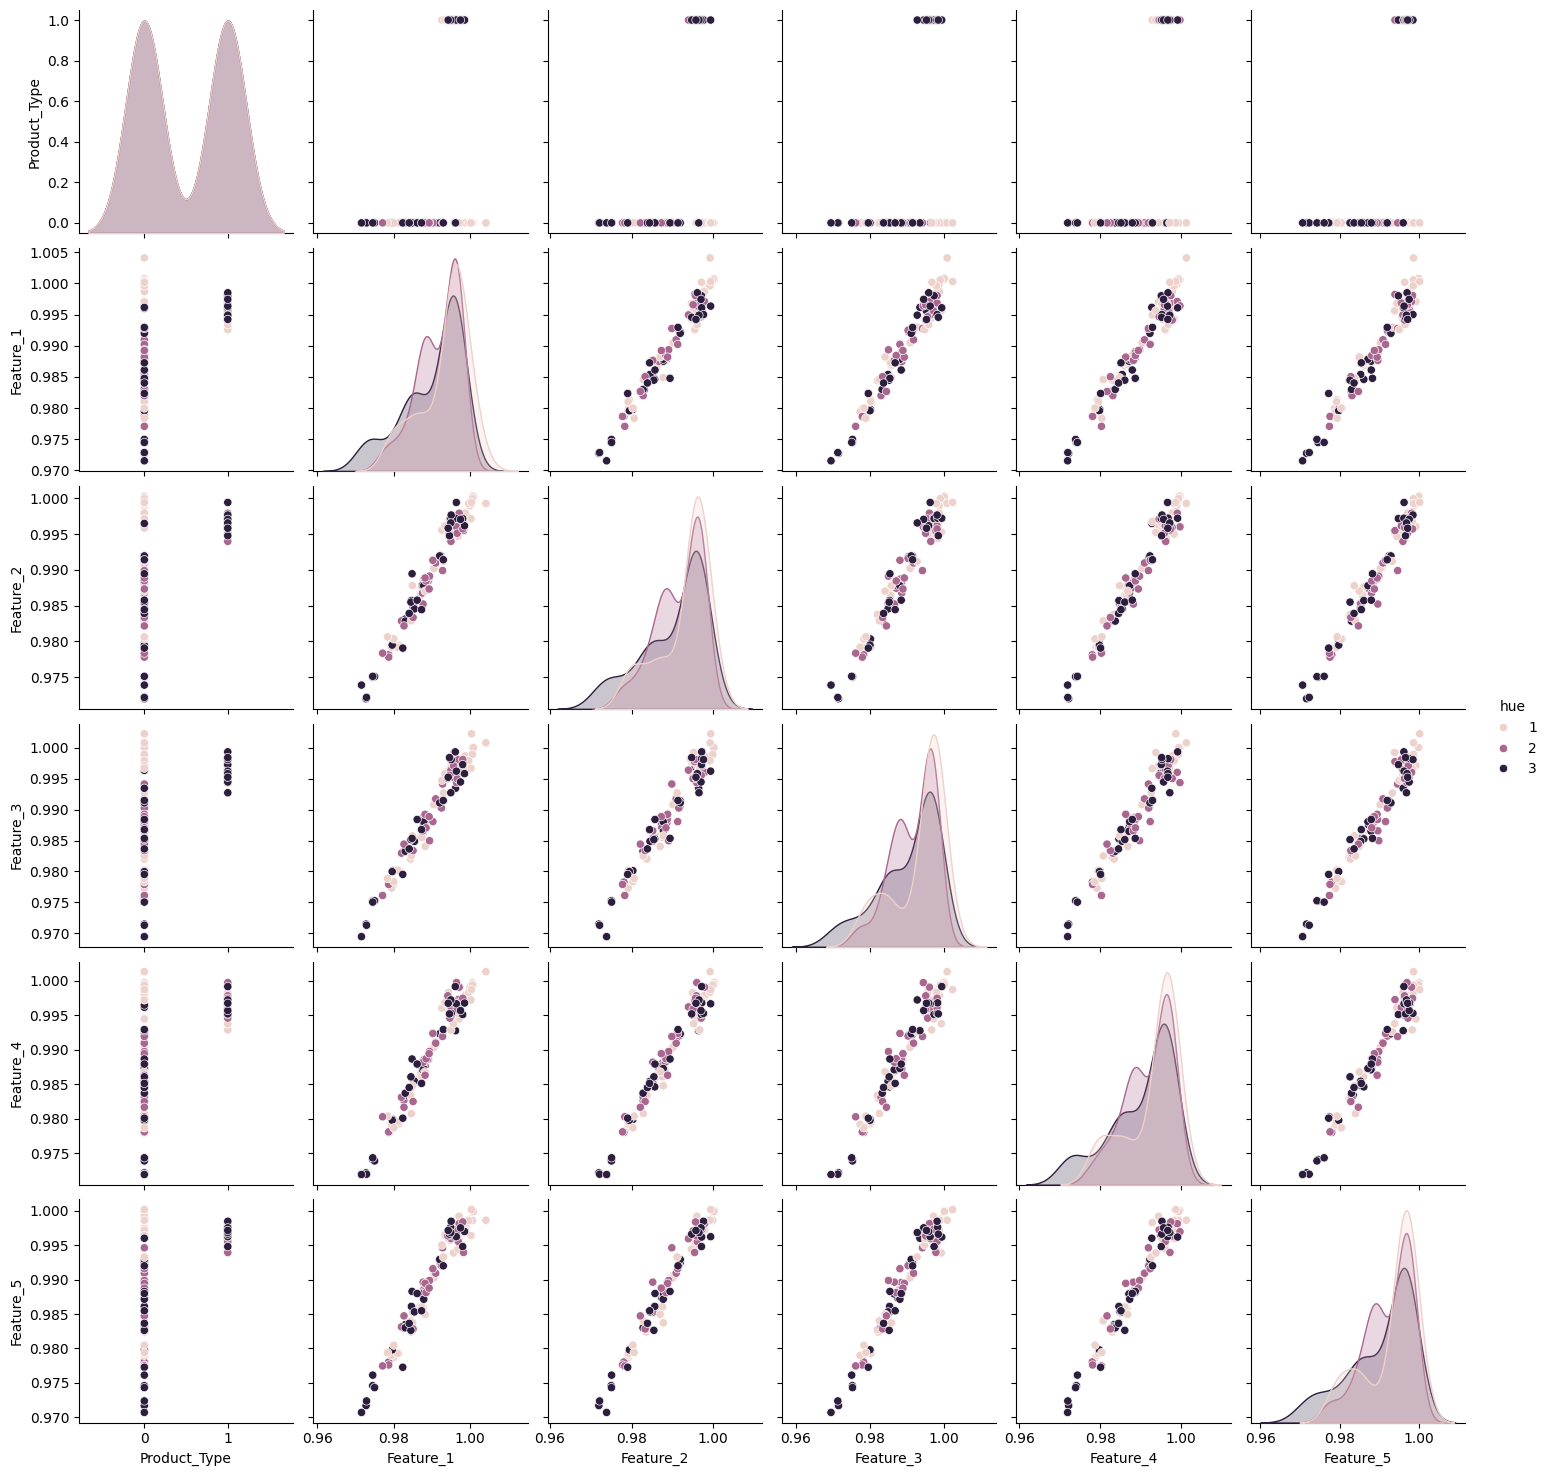

In [ ]:
# Create a new column in all_data for the hue
all_data['hue'] = all_data[['storage_1', 'storage_2', 'storage_3']].idxmax(axis=1).str[-1].astype(int)

# Pass the column name to hue
sns.pairplot(all_data, hue='hue', vars=['Product_Type', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5'])

<Axes: xlabel='Product_Type', ylabel='count'>

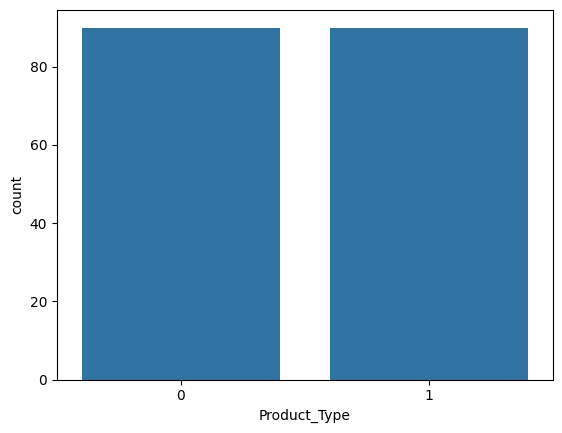

In [ ]:
sns.countplot(x='Product_Type', data=all_data)


<Axes: xlabel='storage_condition', ylabel='count'>

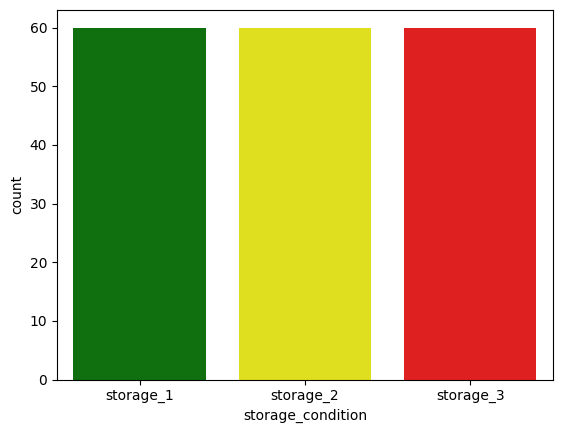

In [ ]:
# Define the custom color palette for storage conditions
custom_palette = {'storage_1': 'green', 'storage_2': 'yellow', 'storage_3': 'red'}

# Determine the condition with the maximum storage value for each row
all_data['storage_condition'] = all_data[['storage_1', 'storage_2', 'storage_3']].idxmax(axis=1)

# Create the count plot with the custom palette and hue set to 'storage_condition'
sns.countplot(x='storage_condition', data=all_data, hue='storage_condition', palette=custom_palette, legend=False)

# Model Definitions

For this task we are using 5 differet ML algorithms
KNN
RF
SVM
LR
MLP

In [13]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):  
    """Plots the confusion matrix."""  
    cm = confusion_matrix(y_true, y_pred)  
    plt.figure(figsize=(8, 6))  
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  
    plt.xlabel('Predicted')  
    plt.ylabel('Actual')  
    plt.title(title)  
    plt.show()  

def classify_model(model, features, target, model_name, pca_components=None, lda_components=False, return_accuracy=False):
    """
    Performs classification with the given model, with optional LDA and PCA for dimensionality reduction.
    
    Args:
        model: Machine learning model.
        features (array-like): Feature matrix.
        target (array-like): Target labels.
        model_name (str): Name of the model for identification.
        pca_components (int, optional): Number of PCA components. If None, PCA is not applied.
        lda_components (bool or int, optional): If True, LDA is applied with n_components=num_classes-1.
        return_accuracy (bool, optional): Whether to return mean accuracy.
        
    Returns:
        float (optional): Mean accuracy if return_accuracy is True.
    """
    num_classes = len(np.unique(target))
    
    # Initialize pipeline steps
    pipeline_steps = [
        ('scaler', StandardScaler())  # Standardize the data
    ]
    
    # Apply LDA if specified
    if lda_components:
        pipeline_steps.append(('lda', LDA(n_components=num_classes - 1)))
    
    # Apply PCA if specified
    if pca_components:
        pipeline_steps.append(('pca', PCA(n_components=pca_components)))
    
    # Add the model to the pipeline
    pipeline_steps.append((model_name, model))
    
    # Create the pipeline
    pipeline = Pipeline(pipeline_steps)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, features, target, cv=cv, scoring='accuracy', n_jobs=-1)
    
    print(f"\n{model_name.upper()} Classification Results "
          f"(LDA Components: {lda_components if lda_components else 'None'}, "
          f"PCA Components: {pca_components if pca_components else 'None'}):")
    print("Cross-Validation Scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean())

    # Predict using cross-validation
    y_pred = cross_val_predict(pipeline, features, target, cv=cv, n_jobs=-1)
    plot_confusion_matrix(target, y_pred, title=f"{model_name.upper()} Confusion Matrix")
    print(classification_report(target, y_pred))
    
    if return_accuracy:
        return cv_scores.mean()  # Return the mean accuracy if requested

def knn(features, target, params, pca_components=None, lda_components=False, return_accuracy=False):
    model = KNeighborsClassifier(**params)
    return classify_model(model, features, target, 'knn', pca_components=pca_components, lda_components=lda_components, return_accuracy=return_accuracy)

def svm(features, target, params, pca_components=None, lda_components=False, return_accuracy=False):
    model = SVC(**params)
    return classify_model(model, features, target, 'svm', pca_components=pca_components, lda_components=lda_components, return_accuracy=return_accuracy)

def rf(features, target, params, pca_components=None, lda_components=False, return_accuracy=False):
    """Random Forest Classifier."""  
    model = RandomForestClassifier(**params) 
    return classify_model(model, features, target, 'rf', pca_components=pca_components, lda_components=lda_components, return_accuracy=return_accuracy)

def lr(features, target, params, pca_components=None, lda_components=False, return_accuracy=False):
    """Logistic Regression Classifier."""  
    model = LogisticRegression(**params)  
    return classify_model(model, features, target, 'lr', pca_components=pca_components, lda_components=lda_components, return_accuracy=return_accuracy)

def mlp(features, target, params, pca_components=None, lda_components=False, return_accuracy=False):
    """Multi-Layer Perceptron Classifier."""  
    model = MLPClassifier(**params)  
    return classify_model(model, features, target, 'mlp', pca_components=pca_components, lda_components=lda_components, return_accuracy=return_accuracy)



# Save the results in json format

In [14]:
import os
import json

# Define the results directory path
results_dir = './results'

# Create results directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

# Function to save results to a JSON file
def save_results_to_file(results, filename):
    """Save classification results to a JSON file in the results directory."""
    file_path = os.path.join(results_dir, filename)
    with open(file_path, 'w') as file:
        json.dump(results, file, indent=4)
    print(f"Results saved to {file_path}")


# Accuracy results  

In [15]:
# Initialize a dictionary to hold accuracy results  
#results_with_storage = {}  
#results_without_storage = {}  

# Function to perform classification with or without dimensionality reduction
def classify_with_dimensionality_reduction(features, target, best_params, pca_components=None, lda_components=False):
    """Classify with dimensionality reduction (either PCA or LDA)."""
    results = {}
    print(f'Product Type classification with parameters considering dimensionality reduction (PCA: {pca_components}, LDA: {lda_components})')

    # Collect accuracy results for each model with or without storage conditions
    results['KNN'] = knn(features, target, best_params['KNN'], pca_components=pca_components, lda_components=lda_components, return_accuracy=True)  
    results['SVM'] = svm(features, target, best_params['SVM'], pca_components=pca_components, lda_components=lda_components, return_accuracy=True)  
    results['Random Forest'] = rf(features, target, best_params['Random Forest'], pca_components=pca_components, lda_components=lda_components, return_accuracy=True)  
    results['Logistic Regression'] = lr(features, target, best_params['Logistic Regression'], pca_components=pca_components, lda_components=lda_components, return_accuracy=True)  
    results['MLP'] = mlp(features, target, best_params['MLP'], pca_components=pca_components, lda_components=lda_components, return_accuracy=True)
    return results

# __Visualization of Classification Accuracies__

In [16]:

# Cell 5: Visualization of Classification Accuracies  
def plot_accuracy_comparisons(results_without_storage, results_with_storage):  
    """Plot accuracy comparisons for models with and without storage conditions."""  
    models = list(results_without_storage.keys())  
    accuracies_without = list(results_without_storage.values())  
    accuracies_with = list(results_with_storage.values())  
    
    x = np.arange(len(models))  # the label locations  
    width = 0.35  # the width of the bars  

    fig, ax = plt.subplots(figsize=(10, 6))  
    bars1 = ax.bar(x - width/2, accuracies_without, width, label='Without Storage')  
    bars2 = ax.bar(x + width/2, accuracies_with, width, label='With Storage')  

    # Add some text for labels, title and custom x-axis tick labels, etc.  
    ax.set_ylabel('Accuracy')  
    ax.set_title('Model Accuracies')  
    ax.set_xticks(x)  
    ax.set_xticklabels(models)  
    ax.legend()  

    # Autolabel function to display accuracy on top of bars  
    def autolabel(bars):  
        """Attach a text label above each bar in *bars*, displaying its height."""  
        for bar in bars:  
            height = bar.get_height()  
            ax.annotate(f'{height:.2f}',  
                        xy=(bar.get_x() + bar.get_width() / 2, height),  
                        xytext=(0, 3),  # 3 points vertical offset  
                        textcoords="offset points",  
                        ha='center', va='bottom')  

    autolabel(bars1)  
    autolabel(bars2)  

    plt.ylim(0, 1)  # Set y-axis limit (0 to 1 for accuracy)  
    plt.show()  


# Product Type Classification without applying dimensionaliy reduction
| **Product Type without considering the storage condition** |

In [17]:
  
# Prepare Data  
target = all_data['Product_Type']
features_pt = all_data.iloc[:, 5:]  # Select features excluding storage conditions  


In [18]:
# Define best parameters for classification without storage conditions  
best_params_without_storage = {  
    'KNN': {'n_neighbors': 1, 'weights': 'uniform'},  
    'Random Forest': {'n_estimators': 160, 'min_samples_split': 15, 'max_depth': None},  
    'SVM': {'C': 37.454637344617396, 'kernel': 'linear'},  
    'Logistic Regression': {'C': 37.454637344617396, 'solver': 'lbfgs', 'max_iter': 1000},
    'MLP': {
    'activation': 'logistic',          # Use logistic activation
    'alpha': 0.01,                     # Regularization strength
    'hidden_layer_sizes': (150,),       # Number of neurons in the hidden layer
    'max_iter': 2000,                   # Number of iterations for optimization
    'solver': 'adam',                   # Use adam solver for faster convergence
    'learning_rate_init': 0.001,        # Initial learning rate for adam solver
    'tol': 1e-4                         # Tolerance for optimization
    }

}  

In [ ]:
# 1. Product Type classification without considering the storage conditions (no dimensionality reduction)

print('Product Type classification without considering the storage conditions')
results_without_storage = classify_with_dimensionality_reduction(features_pt, target, 
                                                              best_params_without_storage, pca_components=False, lda_components=False)

save_results_to_file(results_with_storage, 'results_with_storage.json')

Product Type classification without considering the storage conditions
Product Type classification with parameters considering dimensionality reduction (PCA: False, LDA: False)


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py", line 839, in fit
    return self.partial_fit(X, y, sample_weight)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py", line 875, in partial_fit
    X = self._validate_data(
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 605, in _validate_data
    out = check_array(X, input_name="X", **check_params)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py", line 836, in check_array
    array = array.astype(new_dtype)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py", line 6324, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\internals\managers.py", line 451, in astype
    return self.apply(
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\internals\managers.py", line 352, in apply
    applied = getattr(b, f)(**kwargs)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\internals\blocks.py", line 511, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\dtypes\astype.py", line 242, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\dtypes\astype.py", line 187, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
  File "c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\dtypes\astype.py", line 138, in _astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: 'storage_1'






| **Product Type Classification considering the storage condition** |

Define best parameters for classification considering the storage conditions

In [12]:
# Define best parameters for classification considering the storage conditions  
best_params_with_storage = {  
    'KNN': {'n_neighbors': 1, 'weights': 'uniform'},  
    'Random Forest': {'n_estimators': 160, 'min_samples_split': 15, 'max_depth': None},  
    'SVM': {'C': 37.454637344617396, 'kernel': 'linear'},  
    'Logistic Regression': {'C': 37.4546, 'solver': 'lbfgs', 'max_iter': 1000},  
    'MLP': {'activation': 'logistic', 'alpha': 0.0798, 'hidden_layer_sizes': (150,), 'max_iter': 1000}  
}


Product Type classification parametres considering the storage conditions
Product Type classification with parameters considering dimensionality reduction (PCA: False, LDA: False)

KNN Classification Results (LDA Components: None, PCA Components: None):
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


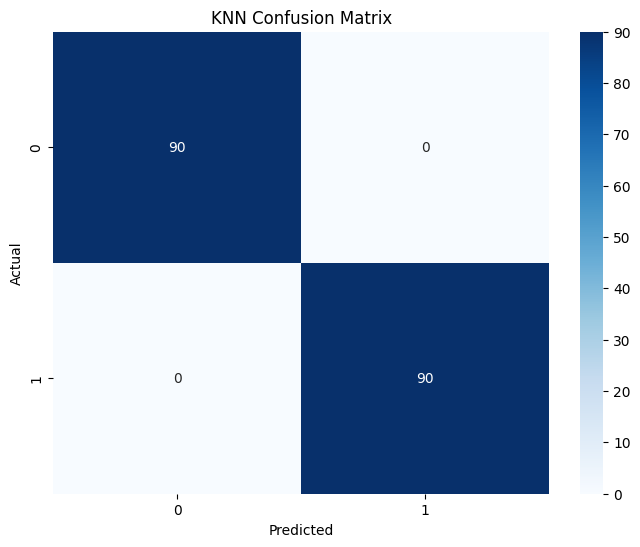

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180


SVM Classification Results (LDA Components: None, PCA Components: None):
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


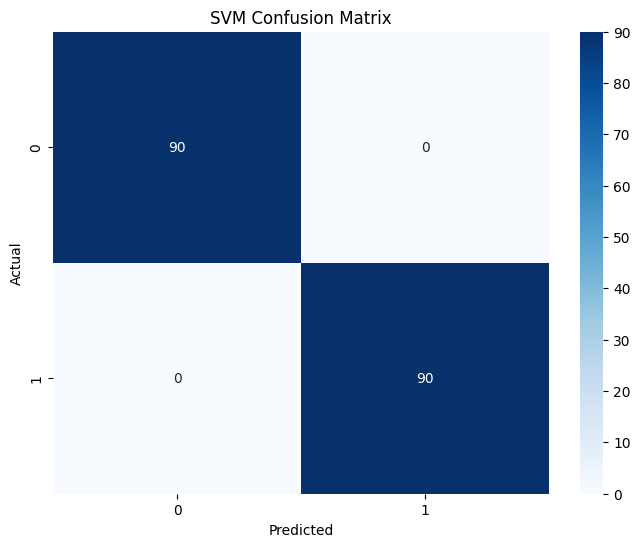

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180


RF Classification Results (LDA Components: None, PCA Components: None):
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833333333333334


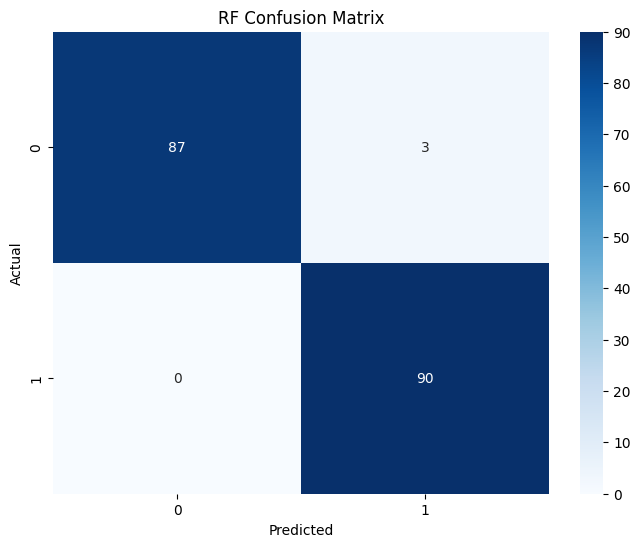

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


LR Classification Results (LDA Components: None, PCA Components: None):
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


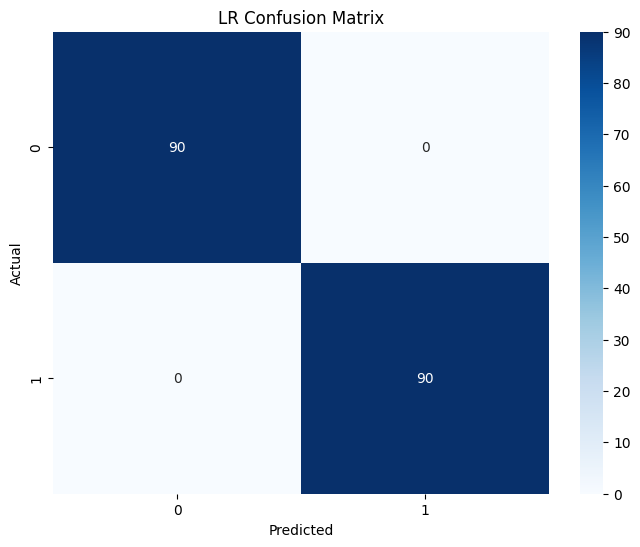

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180


MLP Classification Results (LDA Components: None, PCA Components: None):
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833333333333334


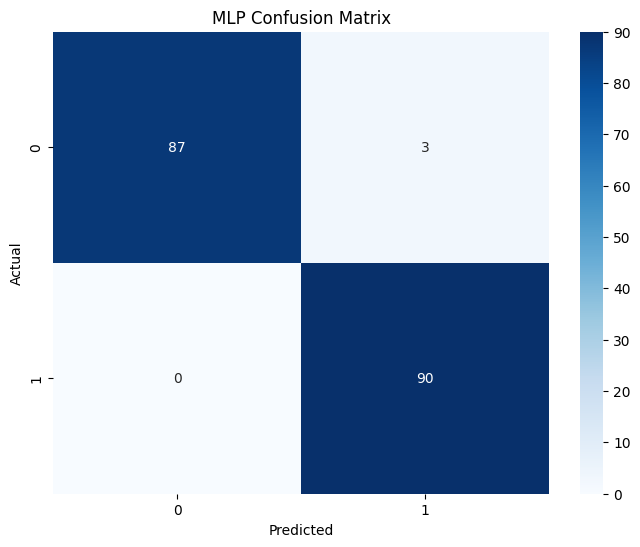

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180

Results saved to ./results/results_without_storage.json


In [13]:
# 2. Product Type classification considering the storage conditions (no dimensionality reduction)
  
# Prepare Data 
features_pt_sc = all_data.iloc[:, 2:] # Select features including storage conditions

print('\nProduct Type classification parametres considering the storage conditions')
results_without_storage = classify_with_dimensionality_reduction(features_pt_sc, target, best_params_with_storage, pca_components=False, lda_components=False)

save_results_to_file(results_without_storage, 'results_without_storage.json')

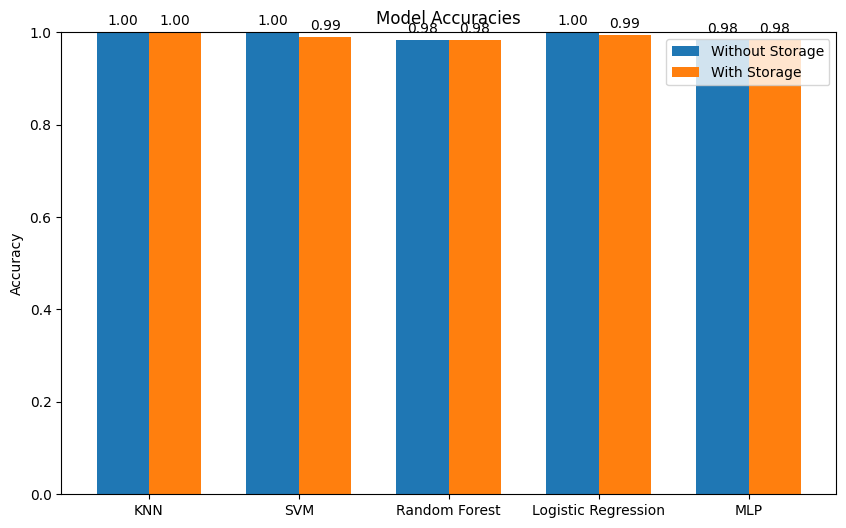

In [14]:
# Plotting the accuracy comparisons  
plot_accuracy_comparisons(results_without_storage, results_with_storage)

In [20]:
add noise 60-180

SyntaxError: invalid syntax (1876766559.py, line 1)

# Classification of Product Types Using LDA Features

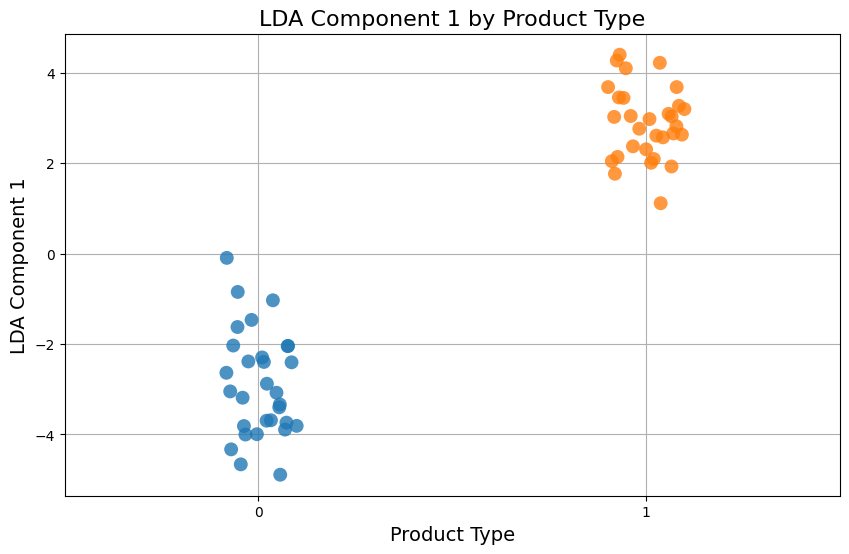

# Product Type Classification
| Product Type without considering the storage condition |


*Prepare the data*

In [15]:
# Prepare Data  
target = all_data['Product_Type']
features_pt = all_data.iloc[:, 5:]  # Select features excluding storage conditions


**Define best parameters for classification without storage conditions**

In [16]:
# Define best parameters for classification without storage conditions  
best_params_without_storage_lda = {  
    'KNN': {'n_neighbors': 1, 'weights': 'uniform'},  
    'Random Forest': {'n_estimators': 160, 'min_samples_split': 15, 'max_depth': None},  
    'SVM': {'C': 37.454637344617396, 'kernel': 'linear'},  
    'Logistic Regression': {'C': 37.454637344617396, 'solver': 'lbfgs', 'max_iter': 1000},  
    'MLP': {'activation': 'logistic', 'alpha': 0.0797542986860233, 'hidden_layer_sizes': (150,), 'max_iter': 1000}  
}  

Product Type classification without considering the storage conditions
Product Type classification with parameters considering dimensionality reduction (PCA: False, LDA: True)

KNN Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.83333333 0.75       0.72222222 0.77777778 0.77777778]
Mean CV Accuracy: 0.7722222222222223


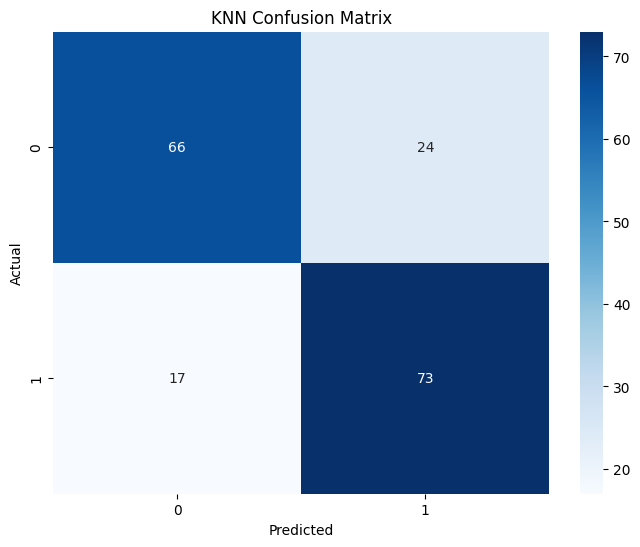

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        90
           1       0.75      0.81      0.78        90

    accuracy                           0.77       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.77      0.77      0.77       180


SVM Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.83333333 0.75       0.72222222 0.77777778 0.77777778]
Mean CV Accuracy: 0.7722222222222223


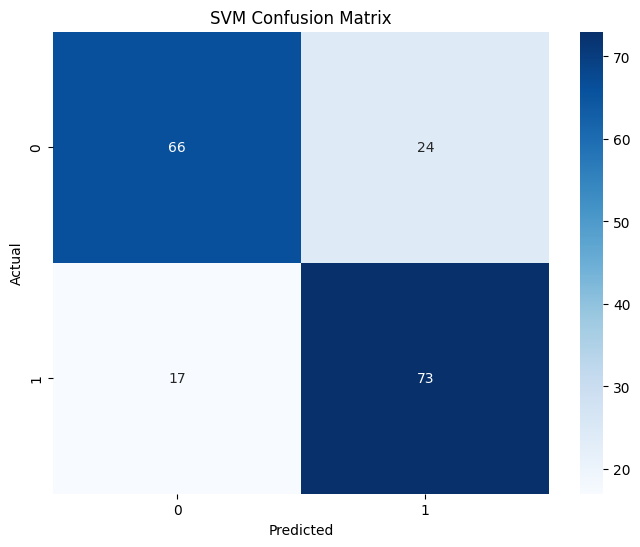

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        90
           1       0.75      0.81      0.78        90

    accuracy                           0.77       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.77      0.77      0.77       180


RF Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.83333333 0.75       0.72222222 0.77777778 0.77777778]
Mean CV Accuracy: 0.7722222222222223


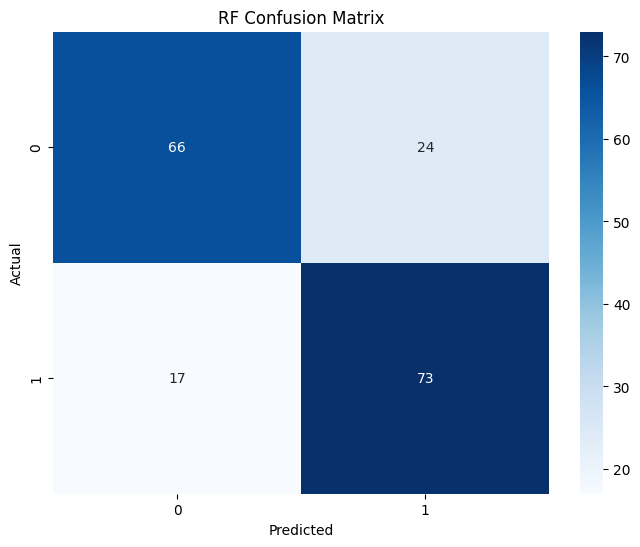

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        90
           1       0.75      0.81      0.78        90

    accuracy                           0.77       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.77      0.77      0.77       180


LR Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.83333333 0.75       0.75       0.77777778 0.77777778]
Mean CV Accuracy: 0.7777777777777778


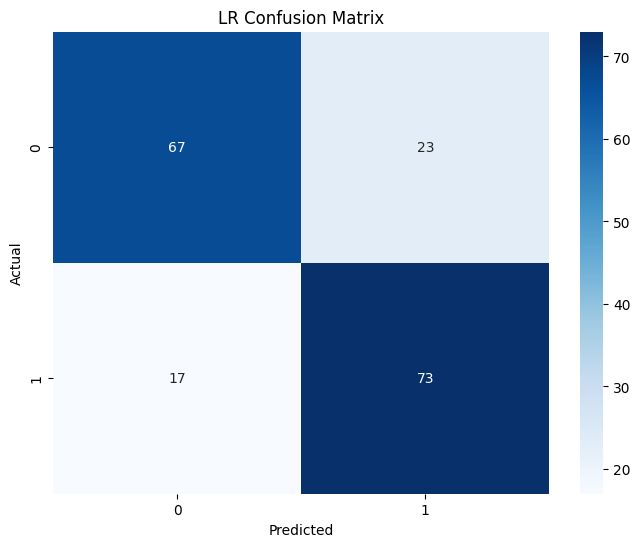

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        90
           1       0.76      0.81      0.78        90

    accuracy                           0.78       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.78      0.78      0.78       180


MLP Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.83333333 0.75       0.75       0.77777778 0.77777778]
Mean CV Accuracy: 0.7777777777777778


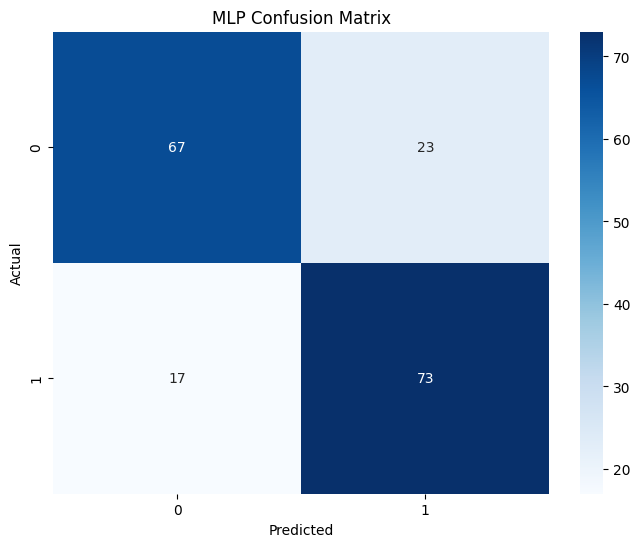

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        90
           1       0.76      0.81      0.78        90

    accuracy                           0.78       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.78      0.78      0.78       180

Results saved to ./results/results_without_storage_lda.json


In [17]:
 # 1.Product Type classification without considering the storage conditions (LDA)

print('Product Type classification without considering the storage conditions')
results_without_storage_lda = classify_with_dimensionality_reduction(
    features_pt, target, best_params_without_storage_lda, pca_components=False, lda_components=True)

save_results_to_file(results_without_storage_lda, 'results_without_storage_lda.json')

**Define best parameters for classification considering the storage conditions(LDA)**

In [18]:
# Define best parameters for classification considering the storage conditions  
best_params_with_storage_lda = {  
    'KNN': {'n_neighbors': 1, 'weights': 'uniform'},  
    'Random Forest': {'n_estimators': 160, 'min_samples_split': 15, 'max_depth': None},  
    'SVM': {'C': 37.454637344617396, 'kernel': 'linear'},  
    'Logistic Regression': {'C': 37.4546, 'solver': 'lbfgs', 'max_iter': 1000},  
    'MLP': {'activation': 'logistic', 'alpha': 0.0798, 'hidden_layer_sizes': (150,), 'max_iter': 1000}  
}


Product Type classification without considering the storage conditions
Product Type classification with parameters considering dimensionality reduction (PCA: False, LDA: True)

KNN Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.91666667 0.94444444 0.72222222 0.75       0.72222222]
Mean CV Accuracy: 0.8111111111111111


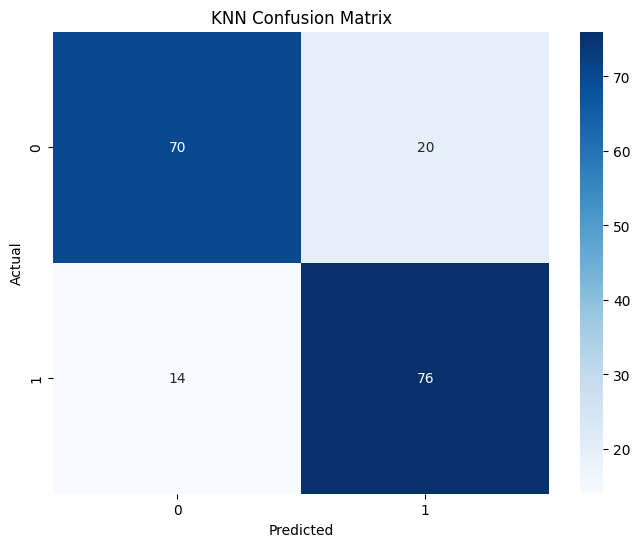

              precision    recall  f1-score   support

           0       0.83      0.78      0.80        90
           1       0.79      0.84      0.82        90

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180


SVM Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.91666667 0.94444444 0.72222222 0.75       0.72222222]
Mean CV Accuracy: 0.8111111111111111


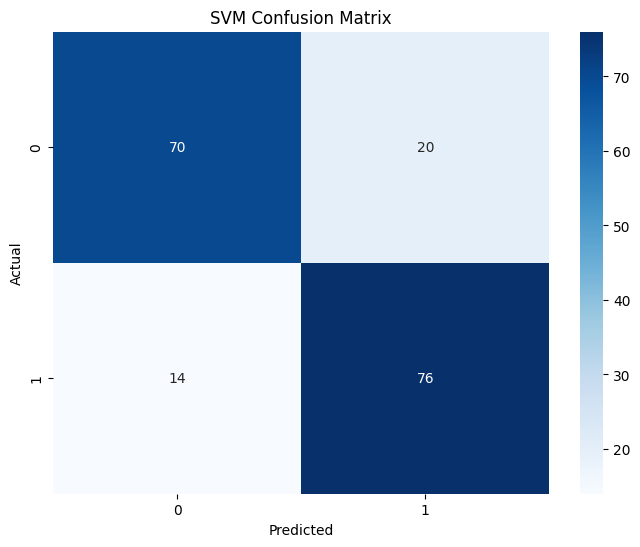

              precision    recall  f1-score   support

           0       0.83      0.78      0.80        90
           1       0.79      0.84      0.82        90

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180


RF Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.91666667 0.94444444 0.72222222 0.75       0.72222222]
Mean CV Accuracy: 0.8111111111111111


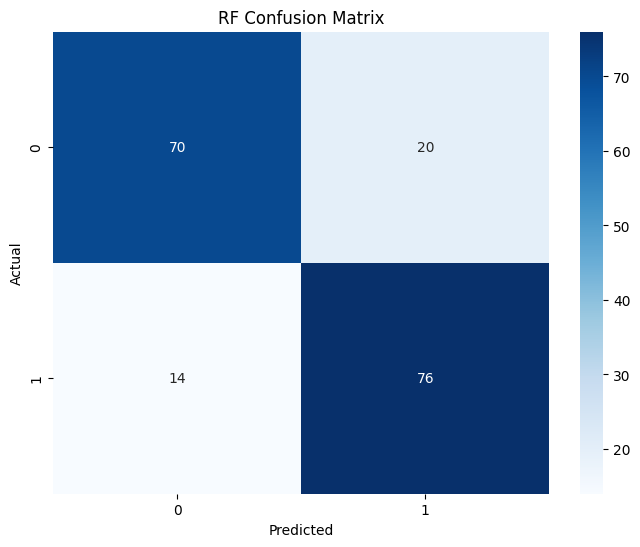

              precision    recall  f1-score   support

           0       0.83      0.78      0.80        90
           1       0.79      0.84      0.82        90

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180


LR Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.91666667 0.94444444 0.72222222 0.75       0.72222222]
Mean CV Accuracy: 0.8111111111111111


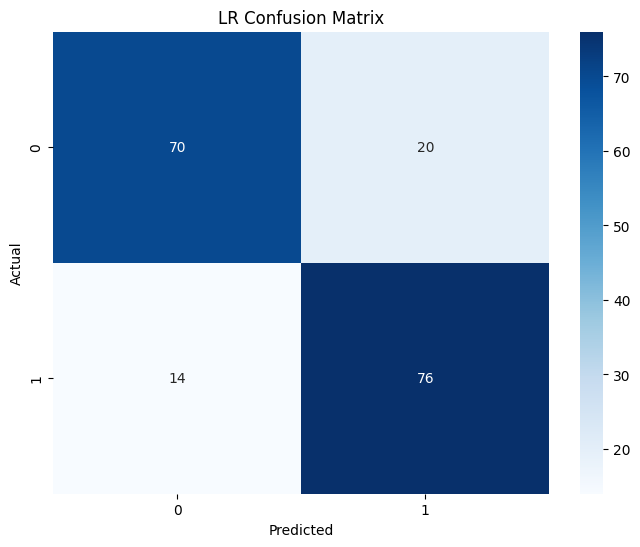

              precision    recall  f1-score   support

           0       0.83      0.78      0.80        90
           1       0.79      0.84      0.82        90

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180


MLP Classification Results (LDA Components: True, PCA Components: None):
Cross-Validation Scores: [0.91666667 0.94444444 0.72222222 0.75       0.72222222]
Mean CV Accuracy: 0.8111111111111111


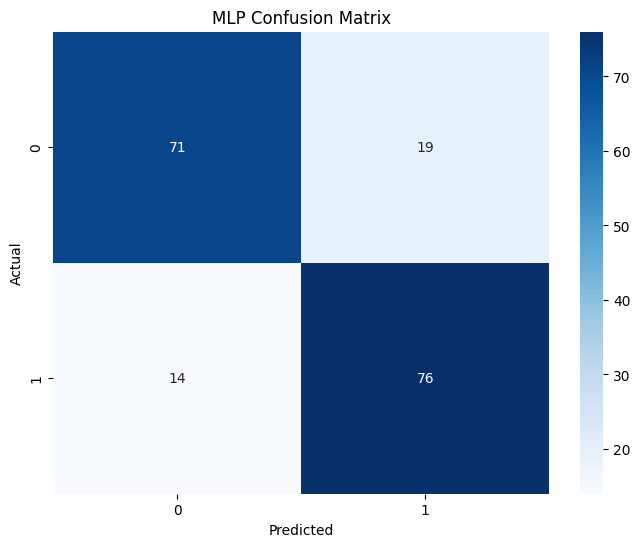

              precision    recall  f1-score   support

           0       0.84      0.79      0.81        90
           1       0.80      0.84      0.82        90

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.82      0.82      0.82       180

Results saved to ./results/results_with_storage_lda.json


In [19]:
 # 2.Product Type classification considering the storage conditions (LDA)

print('Product Type classification without considering the storage conditions')
results_with_storage_lda = classify_with_dimensionality_reduction(
    features_pt_sc, target, best_params_with_storage_lda, pca_components=False, lda_components=True)

save_results_to_file(results_with_storage_lda, 'results_with_storage_lda.json')

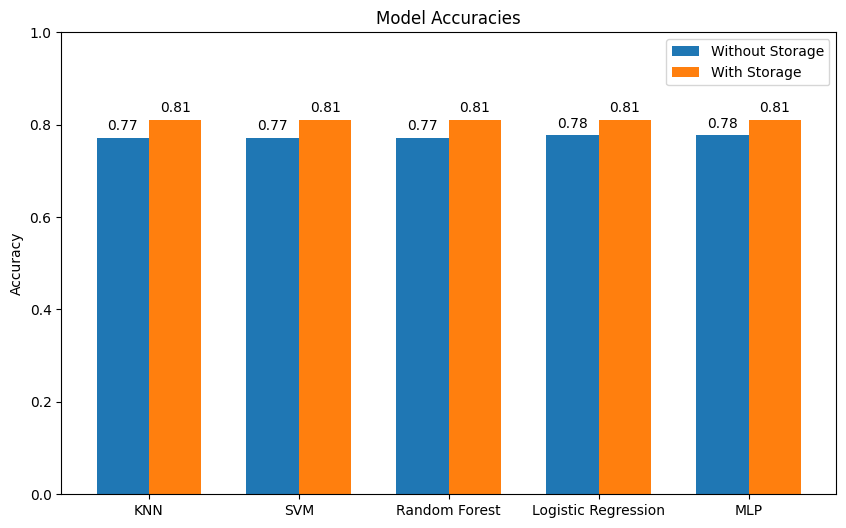

In [20]:
# Plotting the accuracy comparisons  
plot_accuracy_comparisons(results_without_storage_lda, results_with_storage_lda)

# Classification of Product Types Using PCA Features

 **Product Type without considering the storage condition** 

In [21]:
# Prepare Data  
target = all_data['Product_Type']
features_pt = all_data.iloc[:, 5:]  # Select features excluding storage conditions  

**Define best parameters for classification without storage conditions(PCA)**

In [22]:
# Define best parameters for classification without storage conditions  
best_params_without_storage_pca = {  
    'KNN': {'n_neighbors': 1, 'weights': 'uniform'},  
    'Random Forest': {'n_estimators': 160, 'min_samples_split': 15, 'max_depth': None},  
    'SVM': {'C': 5.809303133207778, 'kernel': 'rbf'},  
    'Logistic Regression': {'C': 37.454637344617396, 'solver': 'lbfgs', 'max_iter': 1000},  
    'MLP': {'activation': 'relu', 'alpha': 0.09621720243493492, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000}  
}  

Product Type classification without considering the storage conditions
Product Type classification with parameters considering dimensionality reduction (PCA: 0.95, LDA: False)

KNN Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [1.         0.97222222 1.         1.         1.        ]
Mean CV Accuracy: 0.9944444444444445


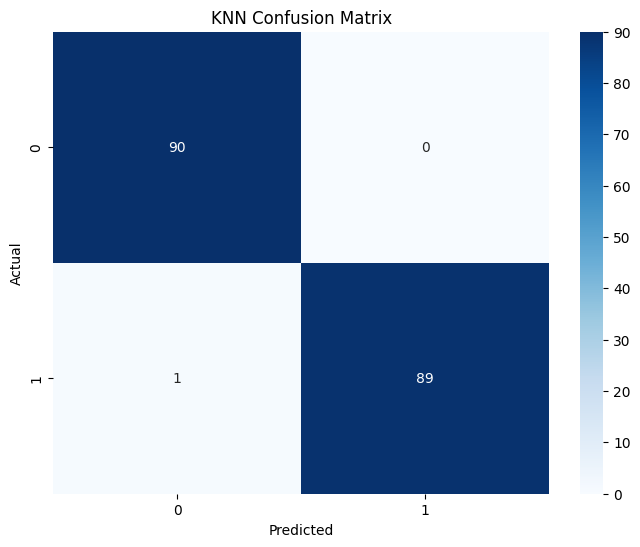

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      0.99      0.99        90

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180


SVM Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 0.94444444 1.         0.97222222]
Mean CV Accuracy: 0.9722222222222221


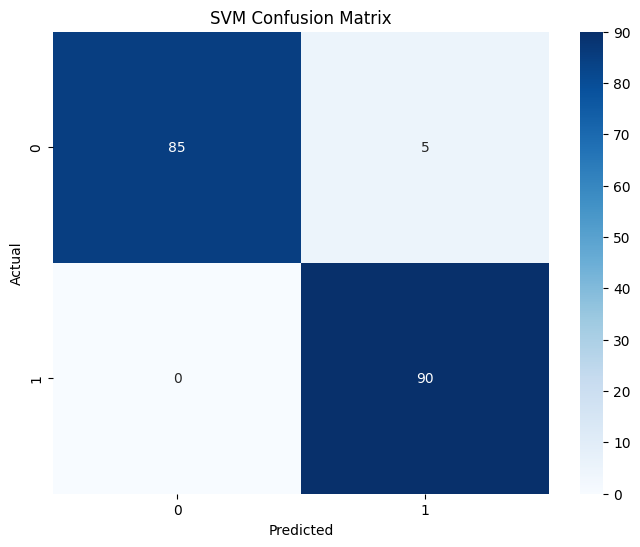

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        90
           1       0.95      1.00      0.97        90

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180


RF Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.94444444 1.         1.         0.97222222]
Mean CV Accuracy: 0.9777777777777776


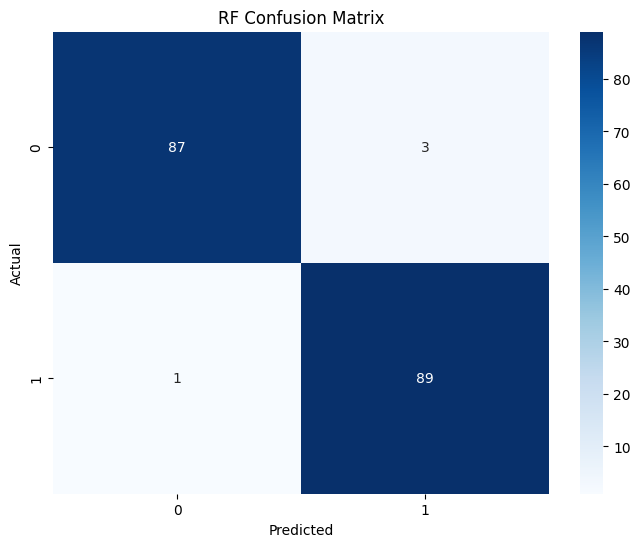

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        90
           1       0.97      0.99      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


LR Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 0.86111111 1.         0.97222222]
Mean CV Accuracy: 0.9555555555555555


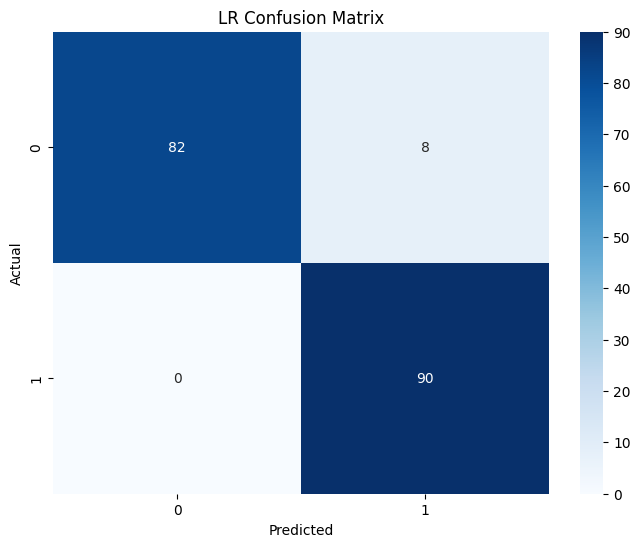

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        90
           1       0.92      1.00      0.96        90

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180


MLP Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 0.94444444 1.         0.97222222]
Mean CV Accuracy: 0.9722222222222221


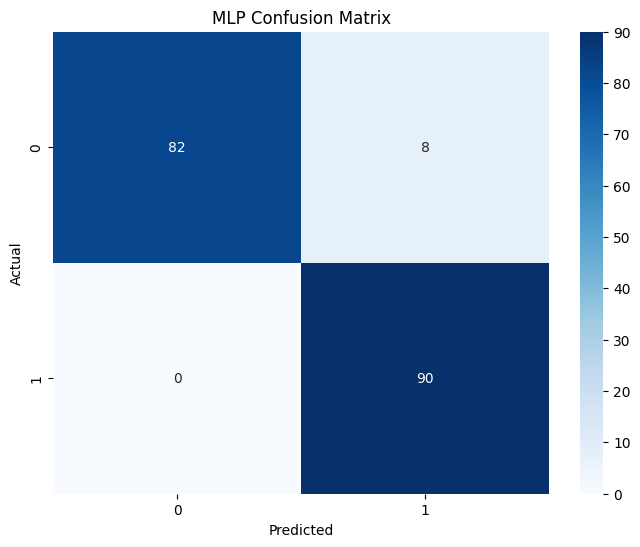

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        90
           1       0.92      1.00      0.96        90

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180



In [23]:
 # 1.Product Type classification without considering the storage conditions (LDA)
pca_component = 0.95
print('Product Type classification without considering the storage conditions')
results_without_storage_pca = classify_with_dimensionality_reduction(
    features_pt, target, best_params_without_storage_pca, pca_components=pca_component, lda_components=False)

**Define best parameters for classification considering the storage conditions(PCA)**

In [24]:
# Define best parameters for classification considering the storage conditions  
best_params_with_storage_pca = {  
    'KNN': {'n_neighbors': 3, 'weights': 'uniform'},  
    'Random Forest': {'n_estimators': 100, 'min_samples_split': 15, 'max_depth': 5},  
    'SVM': {'C': 0.1, 'kernel': 'linear'},  
    'Logistic Regression': {'C': 1.0,'solver': 'lbfgs', 'max_iter': 1000},  
    'MLP': {'activation': 'logistic', 'alpha': 0.0797542986860233, 'hidden_layer_sizes': (150,), 'max_iter': 1000}  
}

Product Type classification without considering the storage conditions
Product Type classification with parameters considering dimensionality reduction (PCA: 0.95, LDA: False)

KNN Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833333333333334


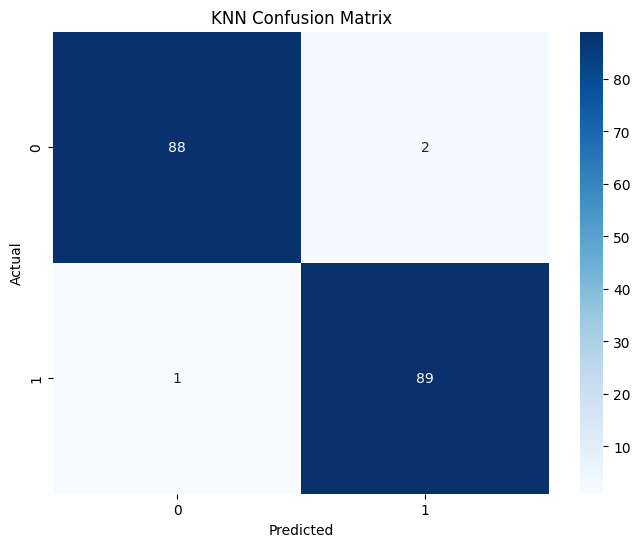

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        90
           1       0.98      0.99      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


SVM Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833333333333334


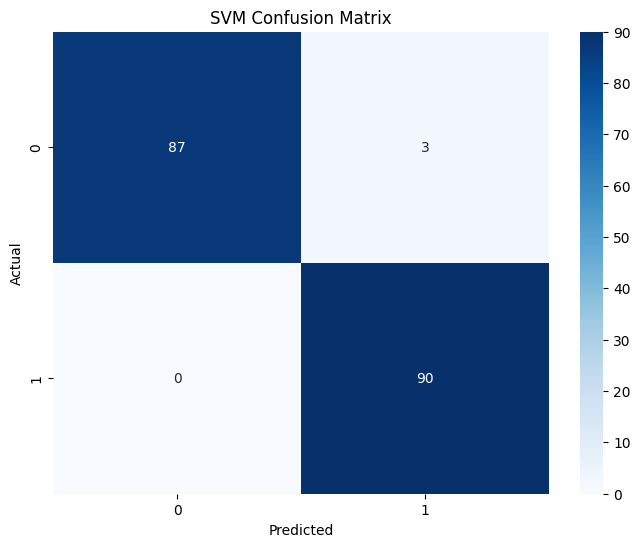

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


RF Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833333333333334


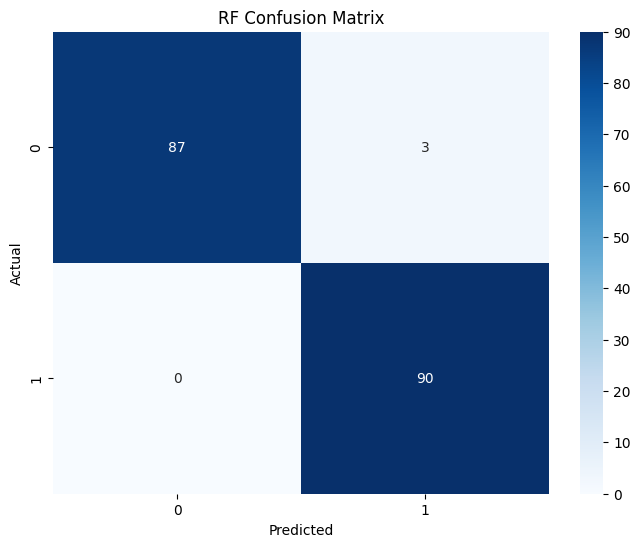

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


LR Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833333333333334


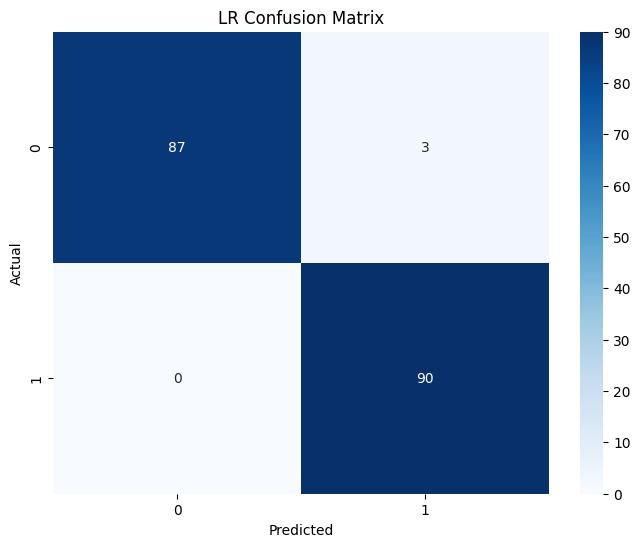

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180


MLP Classification Results (LDA Components: None, PCA Components: 0.95):
Cross-Validation Scores: [0.97222222 0.97222222 1.         1.         0.97222222]
Mean CV Accuracy: 0.9833333333333334


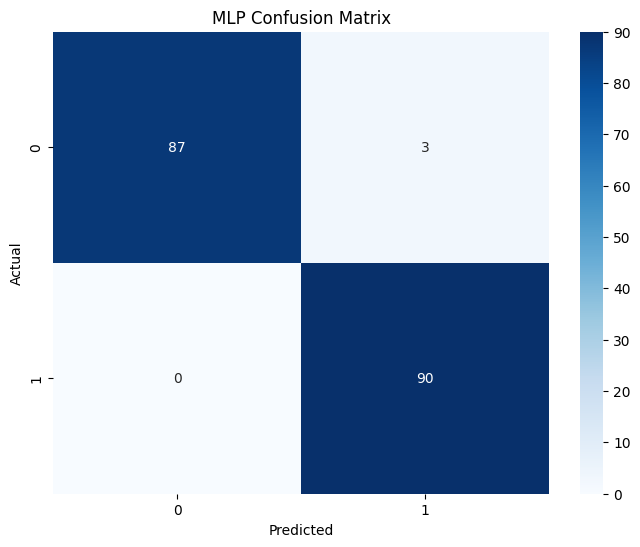

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [25]:
 # 2.Product Type classification considering the storage conditions (pcA)

print('Product Type classification without considering the storage conditions')
results_with_storage_pca = classify_with_dimensionality_reduction(
    features_pt_sc, target, best_params_with_storage_pca, pca_components=pca_component, lda_components=False)

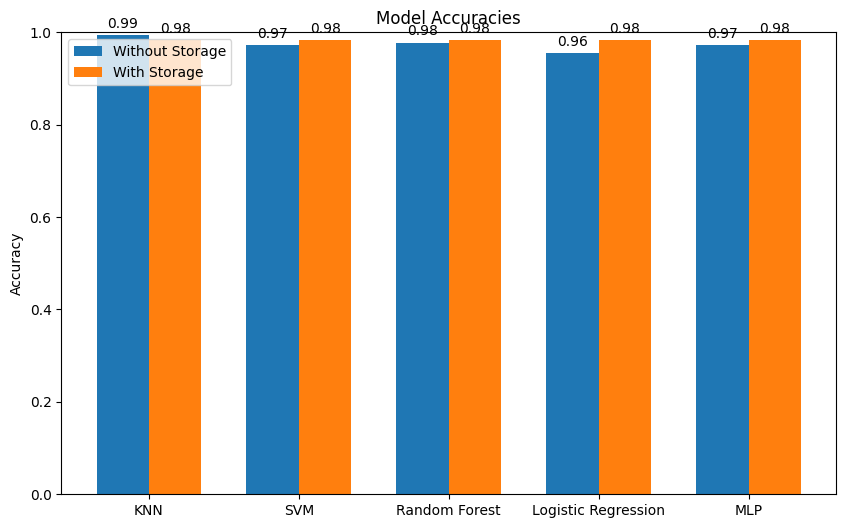

In [26]:
# Plotting the accuracy comparisons  
plot_accuracy_comparisons(results_without_storage_pca, results_with_storage_pca)

In [ ]:
# Collect accuracy results for each model (without storage and no dimension reduction)
results_without_storage['KNN'] = knn(features_pt, target, best_params_without_storage['KNN'], pca_components=None, lda_components=False, return_accuracy=True)  
results_without_storage['SVM'] = svm(features_pt, target, best_params_without_storage['SVM'], pca_components=None, lda_components=False, return_accuracy=True)  
results_without_storage['Random Forest'] = rf(features_pt, target, best_params_without_storage['Random Forest'], pca_components=None, lda_components=False, return_accuracy=True)  
results_without_storage['Logistic Regression'] = lr(features_pt, target, best_params_without_storage['Logistic Regression'], pca_components=None, lda_components=False, return_accuracy=True)  
results_without_storage['ANN'] = mlp(features_pt, target, best_params_without_storage['ANN'], pca_components=None, lda_components=False, return_accuracy=True)  

# 2. Product Type classification considering the storage conditions with dimensionality reduction (either LDA or PCA)
print('\nProduct Type classification with parameters considering the storage conditions')

features_pt_sc = all_data.iloc[:, 2:]  # Select features including storage conditions

# Here, we perform the classification considering storage and dimensionality reduction with options for LDA or PCA
# Example for PCA with 2 components and LDA enabled
results_with_storage['PCA_2'] = classify_with_dimensionality_reduction(features_pt_sc, target, best_params_with_storage, pca_components=2, lda_components=False)
results_with_storage['LDA'] = classify_with_dimensionality_reduction(features_pt_sc, target, best_params_with_storage, pca_components=None, lda_components=True)

# Collect accuracy results for each model (with storage and no dimension reduction)
results_with_storage['KNN'] = knn(features_pt_sc, target, best_params_with_storage['KNN'], pca_components=None, lda_components=False, return_accuracy=True)  
results_with_storage['SVM'] = svm(features_pt_sc, target, best_params_with_storage['SVM'], pca_components=None, lda_components=False, return_accuracy=True)  
results_with_storage['Random Forest'] = rf(features_pt_sc, target, best_params_with_storage['Random Forest'], pca_components=None, lda_components=False, return_accuracy=True)  
results_with_storage['Logistic Regression'] = lr(features_pt_sc, target, best_params_with_storage['Logistic Regression'], pca_components=None, lda_components=False, return_accuracy=True)  
results_with_storage['ANN'] = mlp(features_pt_sc, target, best_params_with_storage['ANN'], pca_components=None, lda_components=False, return_accuracy=True)

# You can continue adding more options for PCA with different component counts if needed